# What Drives High CO₂ Emissions Per Capita?
This notebook uses the Our World in Data CO₂ and greenhouse gas emissions dataset to explore which factors best predict a country’s CO₂ emissions per capita.

1. Data loading and preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Display plots inline
%matplotlib inline

In [2]:
# Use the official raw link (do not assume local file)
RAW_URL = "https://raw.githubusercontent.com/owid/co2-data/refs/heads/master/owid-co2-data.csv"

# Load data using pandas
df = pd.read_csv(RAW_URL)

# Make a copy of the original DataFrame
df_all = df.copy()

# Keep only country-level entities (drop rows where iso_code starts with 'OWID' Or is NaN)
mask_countries = (~df_all["iso_code"].fillna("").str.startswith("OWID")) & (~df_all["iso_code"].isna())
df_countries = df_all.loc[mask_countries].copy()

# Sort by country and year
df_countries = df_countries.sort_values(["country", "year"]).copy()

# Columns used for prediction
cols_to_ffill = [
    "co2_per_capita",
    "gdp",
    "energy_per_capita",
    "energy_per_gdp",
    "co2_per_gdp",
    "co2_per_unit_energy",
    "coal_co2_per_capita",
    "oil_co2_per_capita",
    "gas_co2_per_capita",
    "consumption_co2_per_capita",
    "land_use_change_co2_per_capita",
]

# Only keep columns that actually exist in the DataFrame
cols_to_ffill = [c for c in cols_to_ffill if c in df_countries.columns]

# Some of the columns such as GDP and GDP per capita are empty in the latest year. 
# So instead of blindly taking the latest year, we forward fill the last available value 
# if the corresponding value was NaN or Null.

df_ffilled = (
    df_countries
    .groupby("country", group_keys=False)[cols_to_ffill]
    .ffill()
)

# Put the filled columns back (on a copy to avoid SettingWithCopy warnings)
df_countries_filled = df_countries.copy()
df_countries_filled[cols_to_ffill] = df_ffilled[cols_to_ffill]

# Now drop rows where the *target* is still missing
df_non_null_target = df_countries_filled.dropna(subset=["co2_per_capita"]).copy()

# Finally, take the last available year per country
df_latest = (
    df_non_null_target
    .groupby("country", as_index=False)
    .tail(1)
    .copy()
)

# Show basic info
print("Dataset info:")
print(df_latest.info())

# Show sample data
print("\nSample data:")
print(df_latest[["country", "year", "co2_per_capita", "co2"]].head(15))

# Identify top 10 countries by CO2 per capita
top_10_co2_per_capita = df_latest.nlargest(10, "co2_per_capita")
print("\nTop 10 countries by CO2 emissions per capita:")
print(top_10_co2_per_capita[["country", "co2_per_capita"]])

# Identify top 10 countries by Total CO2 and per capita
top_10_co2_per_capita = df_latest.nlargest(10, "co2")
print("\nTop 10 countries by Total CO2 emissions:")
print(top_10_co2_per_capita[["country", "co2"]])

Dataset info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 213 entries, 274 to 50410
Data columns (total 79 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   country                                    213 non-null    object 
 1   year                                       213 non-null    int64  
 2   iso_code                                   213 non-null    object 
 3   population                                 213 non-null    float64
 4   gdp                                        164 non-null    float64
 5   cement_co2                                 208 non-null    float64
 6   cement_co2_per_capita                      208 non-null    float64
 7   co2                                        213 non-null    float64
 8   co2_growth_abs                             213 non-null    float64
 9   co2_growth_prct                            213 non-null    float64
 10  co2_incl

2. Selecting relevant predictors

We will focus on generic, reusable column selection and avoid hard-coding more than needed. The target variable is co2_per_capita. Predictors include:

- Energy use per person.
- CO₂ intensity of energy and GDP.
- CO₂ per capita by main fossil fuels.

In [3]:
# List all columns 
all_columns = df_latest.columns.tolist()

# Helper function: safely pick columns that exist
def select_existing_columns(df, candidate_cols):
    existing = [col for col in candidate_cols if col in df.columns]
    return existing

# Define candidate predictor columns
candidate_predictors = [
    "energy_per_capita",
    "energy_per_gdp",
    "co2_per_gdp",
    "co2_per_unit_energy",
    "coal_co2_per_capita",
    "oil_co2_per_capita",
    "gas_co2_per_capita",
    "consumption_co2_per_capita",
    "land_use_change_co2_per_capita",
    "gdp",
    "population",
]

predictor_cols = select_existing_columns(df_latest, candidate_predictors)

print("Target column: co2_per_capita")
print("Number of predictor columns:", len(predictor_cols))
print("Predictor columns:", predictor_cols)

Target column: co2_per_capita
Number of predictor columns: 11
Predictor columns: ['energy_per_capita', 'energy_per_gdp', 'co2_per_gdp', 'co2_per_unit_energy', 'coal_co2_per_capita', 'oil_co2_per_capita', 'gas_co2_per_capita', 'consumption_co2_per_capita', 'land_use_change_co2_per_capita', 'gdp', 'population']


3. Energy use per capita and CO₂ per capita

We first examine how energy use per person relates to CO₂ per person.

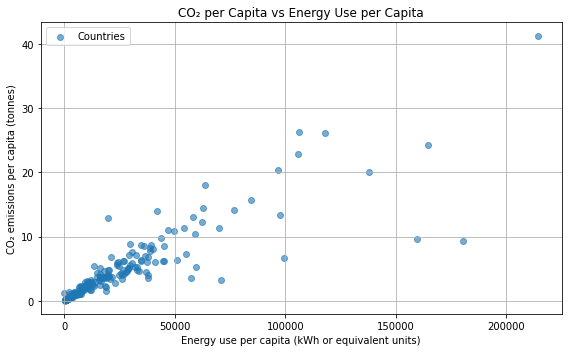

In [4]:
# Filter to rows where both columns exist and are non-null
cols_energy = ["co2_per_capita", "energy_per_capita"]
cols_energy = select_existing_columns(df_latest, cols_energy)

df_energy = df_latest.dropna(subset=cols_energy).copy()

# Scatter plot: energy_per_capita vs co2_per_capita
plt.figure(figsize=(8, 5))
plt.scatter(
    df_energy["energy_per_capita"],
    df_energy["co2_per_capita"],
    alpha=0.6,
    label="Countries",
)
plt.xlabel("Energy use per capita (kWh or equivalent units)")
plt.ylabel("CO₂ emissions per capita (tonnes)")
plt.title("CO₂ per Capita vs Energy Use per Capita")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Higher energy use per person generally corresponds to higher CO₂ emissions per person. This reflects extensive use of electricity, heating/cooling, transport and industry that are still largely powered by fossil fuels in many countries.

4. Fossil fuel mix and carbon intensity

Next, we look at how the fossil fuel mix and the carbon intensity of energy relate to CO₂ per capita.

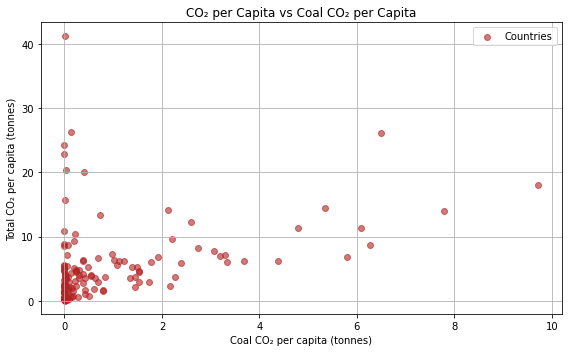

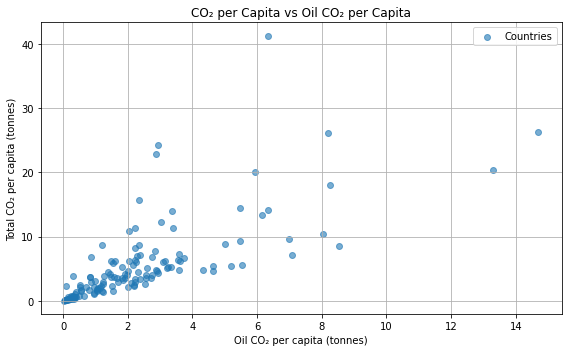

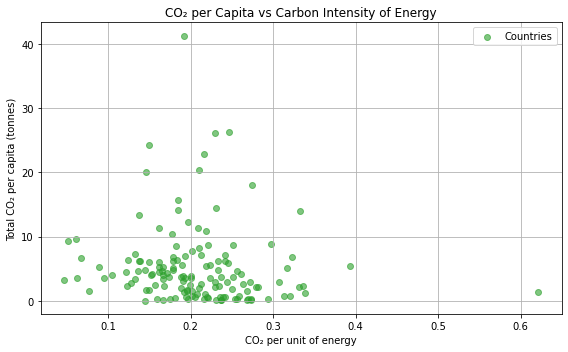

In [5]:
# Prepare a DataFrame with fossil-fuel CO₂ per capita and co2_per_unit_energy
cols_fuels = [
    "co2_per_capita",
    "coal_co2_per_capita",
    "oil_co2_per_capita",
    "gas_co2_per_capita",
    "co2_per_unit_energy",
]
cols_fuels = select_existing_columns(df_latest, cols_fuels)

df_fuels = df_latest.dropna(subset=cols_fuels).copy()

# Example 1: scatter of coal CO2 vs CO2 per capita
plt.figure(figsize=(8, 5))
plt.scatter(
    df_fuels["coal_co2_per_capita"],
    df_fuels["co2_per_capita"],
    alpha=0.6,
    color="firebrick",
    label="Countries",
)
plt.xlabel("Coal CO₂ per capita (tonnes)")
plt.ylabel("Total CO₂ per capita (tonnes)")
plt.title("CO₂ per Capita vs Coal CO₂ per Capita")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Example 2: scatter of oil CO2 vs CO2 per capita
plt.figure(figsize=(8, 5))
plt.scatter(
    df_fuels["oil_co2_per_capita"],
    df_fuels["co2_per_capita"],
    alpha=0.6,
    color="tab:blue",
    label="Countries",
)
plt.xlabel("Oil CO₂ per capita (tonnes)")
plt.ylabel("Total CO₂ per capita (tonnes)")
plt.title("CO₂ per Capita vs Oil CO₂ per Capita")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Example 3: scatter of co2_per_unit_energy vs CO2 per capita
plt.figure(figsize=(8, 5))
plt.scatter(
    df_fuels["co2_per_unit_energy"],
    df_fuels["co2_per_capita"],
    alpha=0.6,
    color="tab:green",
    label="Countries",
)
plt.xlabel("CO₂ per unit of energy")
plt.ylabel("Total CO₂ per capita (tonnes)")
plt.title("CO₂ per Capita vs Carbon Intensity of Energy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Summary of Findings:

These visualizations show that countries where coal and oil CO₂ per person are high, and where the carbon intensity of energy (CO₂ per unit energy) is high, tend to have much higher overall CO₂ emissions per person. This confirms that a fossil‑heavy energy mix is a key predictor of large CO₂ output per capita.


5. Income, efficiency and correlations

We now examine how income (GDP per capita) and intensity indicators relate to CO₂ per person through a correlation analysis.

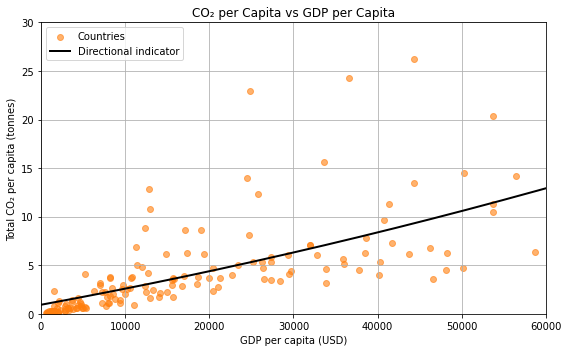

In [6]:
import numpy as np
from scipy.optimize import curve_fit

# Derive GDP per capita generically if gdp and population exist
df_corr = df_latest.copy()

if set(["gdp", "population"]).issubset(df_corr.columns):
    df_corr["gdp_per_capita"] = df_corr["gdp"] / df_corr["population"]


# Scatter + curve gdp_per_capita vs CO2 per capita
plt.figure(figsize=(8, 5))
# Remove rows with missing values for fitting
df_fit = df_corr.dropna(subset=["gdp_per_capita", "co2_per_capita"])

# Define a bell-shaped (Gaussian-like) curve function
def bell_curve(x, a, b, c, d):
    return a * np.exp(-((x - b) ** 2) / (2 * c ** 2)) + d

x = df_fit["gdp_per_capita"].values
y = df_fit["co2_per_capita"].values

# Provide initial guesses for parameters
p0 = [max(y), np.median(x), np.std(x), min(y)]

popt, _ = curve_fit(bell_curve, x, y, p0=p0, maxfev=10000)
x_curve = np.linspace(0, 60000, 300)
y_curve = bell_curve(x_curve, *popt)
plt.scatter(
    df_corr["gdp_per_capita"],
    df_corr["co2_per_capita"],
    alpha=0.6,
    color="tab:orange",
    label="Countries",
)
plt.plot(x_curve, y_curve, color="black", linewidth=2, label="Directional indicator")

plt.xlabel("GDP per capita (USD)")
plt.ylabel("Total CO₂ per capita (tonnes)")
plt.title("CO₂ per Capita vs GDP per Capita")
plt.xlim(0, 60000) 
plt.ylim(0, 30)    
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Summary of the main predictor


1. The dataset contains the latest available CO₂ and energy data for 213 countries.
2. The main target variable is 'co2_per_capita' (CO₂ emissions per person).
3. Key predictors include energy use per capita, fossil fuel CO₂ per capita, and carbon intensity metrics.
4. Visualizations show that higher energy use per person generally leads to higher CO₂ emissions per person.
5. The fossil fuel mix (coal, oil, gas) and the carbon intensity of energy are also strongly related to per capita CO₂ emissions.
6. The top 10 countries by total and per capita CO₂ emissions are dominated by large economies and/or major fossil fuel users.
7. Many columns (such as GDP, methane, nitrous oxide, and trade CO₂) have missing or zero data for the latest year, so we forward filled the data from previous years.

Putting the visuals and correlations together:

* Energy use per person (energy_per_capita) is the most direct driver of high CO₂ per person.
* The fossil fuel composition of that energy, especially coal and oil (coal_co2_per_capita, oil_co2_per_capita, and high co2_per_unit_energy), determines how carbon‑intensive that energy is.
* Higher income (gdp_per_capita) enables higher energy use and more carbon‑intensive lifestyles, unless offset by clean energy and high efficiency (co2_per_gdp, energy_per_gdp).
* In combination, high energy use per capita together with a fossil‑heavy energy mix in relatively high‑income economies is the strongest predictor of large CO₂ output per capita across countries in the OWID dataset.

